<a href="https://colab.research.google.com/github/tutopasini/exoplanets_search/blob/main/IA_Exoplanetas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivação
A ideia do nosso projeto é treinar um modelo capaz de identificar sistemas solares que possuem ao menos um exoplaneta em órbita com um desempenho aceitável.

Como os planetas não emitem luz, é necessário observar os dados de iluminação das estrelas. Através de padrões na variações da emissão de luz, é possível identificar possíveis corpos celestes em órbita nessa estrela.

O dataset pode ser encontrado neste [link](https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data).

**Questão de pesquisa: "É possível prever com precisão a existência de exoplanetas utilizando algoritmos de deep learning?"**

In [ ]:
!pip install -q kaggle

In [ ]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import timeit
from keras import backend as K
from keras import metrics, regularizers
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Activation, concatenate, Dropout, Conv1D, MaxPool1D, Flatten, Dense
from keras.layers import BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Bidirectional
from keras.layers import cudnn_recurrent
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from google.colab import files
from scipy import ndimage
from scipy.signal import savgol_filter
from scipy.ndimage.filters import uniform_filter1d
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, normalize 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Baixando dataset do Kaggle

Selecionar o arquivo kaggle.json para comunicação com a API do kaggle.



In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
# Baixa e descompacta o dataset
!kaggle datasets download -d keplersmachines/kepler-labelled-time-series-data
!unzip kepler-labelled-time-series-data.zip

 63% 35.0M/55.9M [00:01<00:01, 18.4MB/s]
100% 55.9M/55.9M [00:01<00:00, 39.9MB/s]
Archive:  kepler-labelled-time-series-data.zip
  inflating: exoTest.csv             
  inflating: exoTrain.csv            


# Carregando o dataset

Carrega o .csv como um dataframe do pandas.

In [ ]:
X_train = pd.read_csv("exoTrain.csv")
X_test = pd.read_csv("exoTest.csv")

A seguir, vamos separar os labels do restantes das features. Os dados já vieram separados em um conjunto de treino (exoTrain) e testes (exoTest)

In [ ]:
# Obs.: Faz -1 pois os labels estão como 1 e 2 e é necessário ajustar para 0 e 1
y_train = X_train['LABEL'] -1
X_train = X_train.drop('LABEL',axis=1)
y_test = X_test['LABEL'] -1
X_test = X_test.drop('LABEL',axis=1)

# Entendendo o dataset

Nesta seção será explicada a estrutura do dataset através dos dados de treino.

In [ ]:
X_train.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,-195.99,...,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,-24.68,...,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,224.02,...,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,70.31,...,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,-964.35,...,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
X_train.describe()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.00000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,1.410852e+02,1.124563e+02,1.050821e+02,7.720985e+01,60.143330,17.630999,-54.355089,-103.08460,-144.560114,-113.322037,-68.828616,-32.839733,31.196475,88.517940,175.080436,233.700224,281.801687,4.643881e+02,5.347781e+02,5.686202e+02,5.575065e+02,5.667802e+02,5.469081e+02,1.775987e+02,1.977492e+02,2.291148e+02,2.441020e+02,2.501690e+02,2.613476e+02,2.326228e+02,1.826577e+02,...,8.001983e+02,8.456118e+02,7.564445e+02,116.982994,158.543973,129.188885,5.817181,-97.778421,-84.500629,-2.522744,125.509414,354.448954,6.254212e+02,8.012768e+02,106.772064,80.353945,12.455127,-94.172579,-181.646112,-320.240619,-358.358437,-323.468262,-281.609027,-213.522064,-107.086774,-110.572898,-71.794968,-31.777614,72.747847,126.815573,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,1.942289e+04,1.832810e+04,1.768321e+04,1.731920e+04,16647.817648,16725.088231,17162.322247,17356.98839,16979.436723,16011.508248,15118.835589,14255.363528,14048.475841,14618.614614,15246.020915,16803.416700,17930.530299,2.523553e+04,2.704750e+04,2.964609e+04,3.315534e+04,3.679672e+04,4.144422e+04,2.071160e+04,2.108089e+04,2.144121e+04,2.175216e+04,2.180420e+04,2.164199e+04,2.132321e+04,2.115301e+04,...,5.116648e+04,5.829319e+04,5.898207e+04,16075.902775,16263.350901,15613.273881,14397.292446,14887.907167,14466.376116,12079.533421,12455.557157,20116.003038,3.307799e+04,4.613980e+04,15648.242604,15514.533197,14142.137616,13113.457203,13161.476260,14165.866392,15083.632082,14587.243316,13548.583112,11544.505620,10369.103689,10653.997273,10238.433598,10849.383610,16548.155180,20119.224581,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,-2.223300e+05,-2.279016e+05,-2.996757e+05,-4.453612e+05,-557042.690000,-695994.840000,-815633.560000,-880865.85000,-892477.410000,-

O dataset conta com 5087 observações, ou seja, 5087 estrelas que foram observadas por um determinado período de tempo.
Cada estrela possui uma coluna de label indicando se foi detectado ao menos um exoplaneta orbitando a estrela e 3197 colunas com a intensidade da luz dessa estrela em um determinado momento no tempo.

Por estar completamente identificado com as classes que pretendemos classificar, é um caso de ensino supervisionado.
Além disso, são apenas duas classes (possui ou não um exoplaneta), então deve ser tratado como um problema de classificação binária.

Agora, vamos contar quantas estrelas possuem um exoplaneta entre as 5087 observadas.

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

0    5050
1      37
Name: LABEL, dtype: int64
0    565
1      5
Name: LABEL, dtype: int64


A grande maioria das observações são de estrelas que não possuem exoplaneta em órbita. Para não deixar a rede com um forte viés para estrelas sem exoplanetas, o ideal seria balancear esses dados.

A seguir, algumas visualizações da variação dos dados em estrelas com e sem exoplanetas

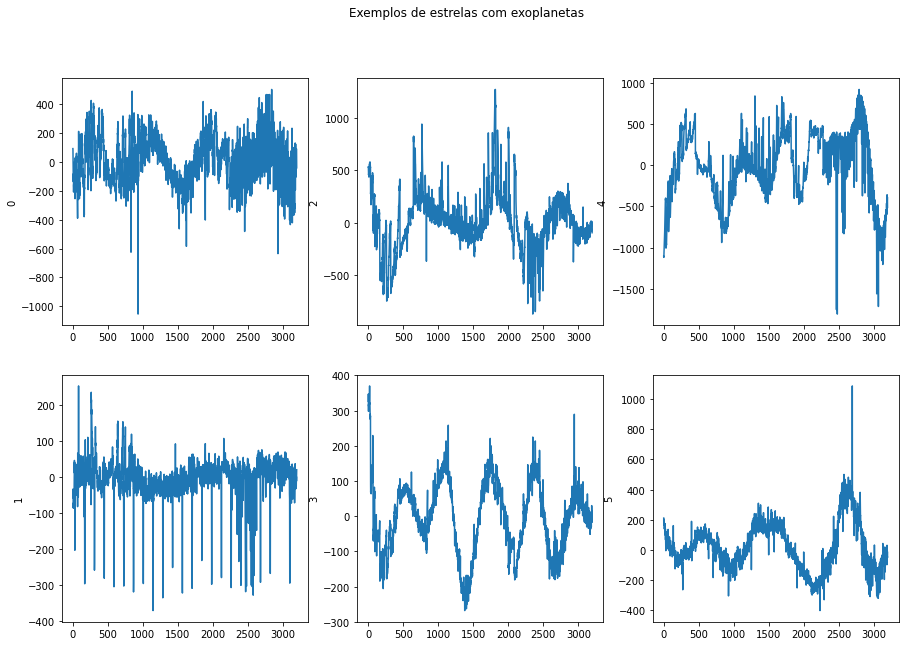

In [ ]:
x = 3
y = 2
fig, axes = plt.subplots(y, x, figsize=(x*5, y*5))
fig.suptitle('Exemplos de estrelas com exoplanetas')

idx=0
for i in range(x):
  for j in range(y):
    sns.lineplot(ax=axes[j, i], x=range(len(X_train.columns)), y=X_train[y_train == 1].iloc[idx])
    idx+=1

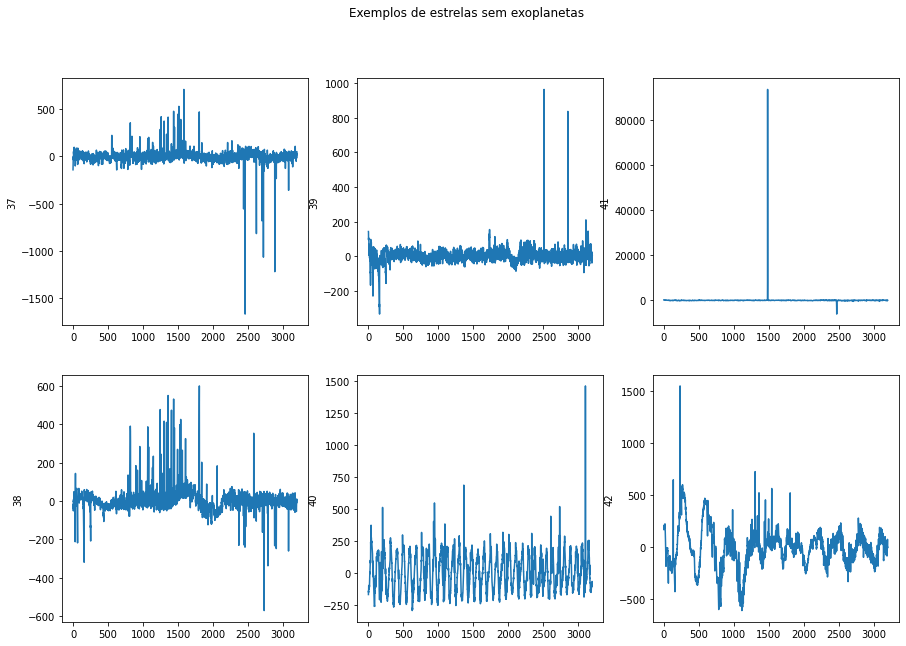

In [ ]:
x = 3
y = 2
fig, axes = plt.subplots(y, x, figsize=(x*5, y*5))
fig.suptitle('Exemplos de estrelas sem exoplanetas')

idx=0
for i in range(x):
  for j in range(y):
    sns.lineplot(ax=axes[j, i], x=range(len(X_train.columns)), y=X_train[y_train == 0].iloc[idx])
    idx+=1

A partir dos dados, é possível verificar alguns outliers bem evidentes que acabam distorcendo os dados.

# Processando os dados
Nesta etapa serão realizados processamentos sobre os dados para que fiquem o mais otimizado possível para uso com os modelos de Machine Learning.

## Tratando valores nulos



In [ ]:
# Verifica se há algum valor nulo nos dados de treino
null_count = (X_train.isnull().sum())
print(null_count[null_count > 0])

# Verifica se há algum valor nulo nos dados de teste
null_count = (X_test.isnull().sum())
print(null_count[null_count > 0])

Series([], dtype: int64)
Series([], dtype: int64)


Não há valores nulos em ambos os datasets, tanto de treino como de teste, então não precisamos tratar isso.

## Normalizando as features
Aqui estamos normalizando todas as features para uma média 0 e desvio padrão 1.

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train)

[[-0.00235557 -0.00205404 -0.00579778 ...  0.0341983   0.02736753
   0.01805157]
 [-0.00852774 -0.0074516  -0.00938685 ...  0.03109682  0.02803863
   0.02216476]
 [ 0.01804893  0.01868969  0.01673115 ...  0.02910084  0.02275218
   0.01410023]
 ...
 [ 0.00599336  0.00685579  0.00523005 ...  0.03572195  0.03191466
   0.02628002]
 [-0.00654212 -0.00580352 -0.00686528 ...  0.0299112   0.0266614
   0.02060995]
 [ 0.00831333  0.00815701  0.00666449 ...  0.02978874  0.02618942
   0.02271046]]


## Balanceamento

A base de dados tem um desbalanceamento entre os sistemas solares que tem exoplaneta (37) e os que não os tem (5050). Isso pode causa um forte viés ao tentar classificar dados reais. Por isso foi aplicado o metodo SMOTE (Synthetic Minority Oversampling Technique) para popular a classe minoritaria a fim de balancear os dados de treino. 

In [ ]:
# UPSAMPLING: SMOTE
X_total = X_train.copy()
os =  SMOTE(sampling_strategy='minority')
X_upsampling , y_upsampling = os.fit_sample(X_total, y_train)

print("Distribuição antes do balanceamento {}".format(Counter(y_train)))
print("Distribuição depois do balanceamento {}".format(Counter(y_upsampling)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Distribuição antes do balanceamento Counter({0: 5050, 1: 37})
Distribuição depois do balanceamento Counter({1: 5050, 0: 5050})


# Treinando os modelos

##Algoritmos

Nossa solução consiste em utilizar um algoritmo de RNN com um algoritmo CNN. Utilizaremos o algoritmo LSTM, que é uma arquitetura de rede neural recorrente (RNN). A LSTM provou ser um modelo eficaz para classificação de séries temporais, já que esse modelo de arquitetura tem conexões de feedback. E utilizaremos de forma combinada uma CNN de 1 dimensão e 4 camadas, que também traz bons resultados em séries temporais.

## Modelo MLP (Multilayer Perceptron)
Uma rede neural densa simples MLP: duas camadas densas com 64 neurônios cada.

In [ ]:
modelS = Sequential()
modelS.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
modelS.add(Dense(units=64, activation='relu'))
modelS.add(Dense(units=1, activation='sigmoid'))
modelS.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
modelS.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                204672    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 208,897
Trainable params: 208,897
Non-trainable params: 0
_________________________________________________________________


Vamos primeiro testar o modelo com o conjunto de dados original

Epoch 1/10
159/159 [==============================] - 1s 4ms/step - loss: 0.0795 - accuracy: 0.9919 - val_loss: 0.0455 - val_accuracy: 0.9912
Epoch 2/10
159/159 [==============================] - 1s 3ms/step - loss: 0.0440 - accuracy: 0.9927 - val_loss: 0.0468 - val_accuracy: 0.9912
Epoch 3/10
159/159 [==============================] - 1s 3ms/step - loss: 0.0444 - accuracy: 0.9927 - val_loss: 0.0475 - val_accuracy: 0.9912
Epoch 4/10
159/159 [==============================] - 1s 3ms/step - loss: 0.0406 - accuracy: 0.9929 - val_loss: 0.0479 - val_accuracy: 0.9912
Epoch 5/10
159/159 [==============================] - 1s 3ms/step - loss: 0.0393 - accuracy: 0.9929 - val_loss: 0.0501 - val_accuracy: 0.9912
Epoch 6/10
159/159 [==============================] - 1s 3ms/step - loss: 0.0368 - accuracy: 0.9929 - val_loss: 0.0519 - val_accuracy: 0.9912
Epoch 7/10
159/159 [==============================] - 1s 3ms/step - loss: 0.0359 - accuracy: 0.9931 - val_loss: 0.0603 - val_accuracy: 0.9912
Epoch 

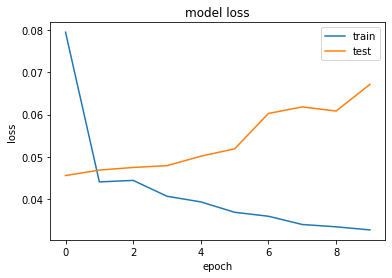

In [ ]:
histS = modelS.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

In [ ]:
plt.plot(histS.history['loss'])
plt.plot(histS.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
predict = model.predict_classes(y_test)
print(confusion_matrix(y_test['new1'], predict))
print(classification_report(testy['new1'], predict))

E então testar com o conjunto de dados após o balanceamento

Epoch 1/10
316/316 [==============================] - 1s 4ms/step - loss: 0.5837 - accuracy: 0.7034 - val_loss: 0.3270 - val_accuracy: 0.9351
Epoch 2/10
316/316 [==============================] - 1s 3ms/step - loss: 0.2681 - accuracy: 0.9147 - val_loss: 0.1738 - val_accuracy: 0.9649
Epoch 3/10
316/316 [==============================] - 1s 3ms/step - loss: 0.0886 - accuracy: 0.9793 - val_loss: 0.2495 - val_accuracy: 0.9702
Epoch 4/10
316/316 [==============================] - 1s 3ms/step - loss: 0.0400 - accuracy: 0.9944 - val_loss: 0.3013 - val_accuracy: 0.9860
Epoch 5/10
316/316 [==============================] - 1s 3ms/step - loss: 0.0185 - accuracy: 0.9971 - val_loss: 0.3868 - val_accuracy: 0.9772
Epoch 6/10
316/316 [==============================] - 1s 3ms/step - loss: 0.0101 - accuracy: 0.9985 - val_loss: 0.4291 - val_accuracy: 0.9807
Epoch 7/10
316/316 [==============================] - 1s 4ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.4811 - val_accuracy: 0.9807
Epoch 

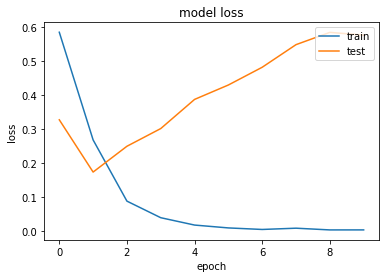

In [ ]:
histS = modelS.fit(X_upsampling, y_upsampling, batch_size=32, epochs=10, validation_data=(X_test, y_test))

In [ ]:
plt.plot(histS.history['loss'])
plt.plot(histS.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Modelo RNN + CNN



In [ ]:
ip = Input(shape=(3197, 1))
# LSTM
x = Permute((2, 1))(ip)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(128)(x)
x = Dropout(0.25)(x)

y = Conv1D(filters=16, kernel_size=11, activation='relu')(ip)
y = MaxPool1D(strides=4)(y)
y = BatchNormalization()(y)
y = Conv1D(filters=32, kernel_size=11, activation='relu')(y)
y = MaxPool1D(strides=4)(y)
y = BatchNormalization()(y)
y = Conv1D(filters=64, kernel_size=11, activation='relu')(y)
y = MaxPool1D(strides=4)(y)
y = BatchNormalization()(y)
y = Conv1D(filters=128, kernel_size=11, activation='relu')(y)
y = MaxPool1D(strides=4)(y)
y = Flatten()(y)
y = Dropout(0.25)(y)
y = Dense(64, activation='relu')(y)

#Concatenate
x = concatenate([x, y])
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(ip, out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3197, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3187, 16)     192         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 797, 16)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 797, 16)      64          max_pooling1d[0][0]              
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
159/159 [==============================] - 22s 137ms/step - loss: 0.0660 - accuracy: 0.9864 - val_loss: 0.0607 - val_accuracy: 0.9912
Epoch 2/10
159/159 [==============================] - 21s 134ms/step - loss: 0.0488 - accuracy: 0.9927 - val_loss: 0.0565 - val_accuracy: 0.9912
Epoch 3/10
159/159 [==============================] - 21s 132ms/step - loss: 0.0441 - accuracy: 0.9927 - val_loss: 0.0504 - val_accuracy: 0.9912
Epoch 4/10
159/159 [==============================] - 21s 131ms/step - loss: 0.0458 - accuracy: 0.9927 - val_loss: 0.0660 - val_accuracy: 0.9912
Epoch 5/10
159/159 [==============================] - 21s 133ms/step - loss: 0.0421 - accuracy: 0.9927 - val_loss: 0.0532 - val_accuracy: 0.9912
Epoch 6/10
159/159 [==============================] - 22s 136ms/step - loss: 0.0364 - accuracy: 0.9931 - val_loss: 0.0550 - val_accuracy: 0.9912
Epoch 7/10
159/159 [==============================] - 21s 134ms/step - loss: 0.0348 - accuracy: 0.9937 - val_loss: 0.0521 - val_ac

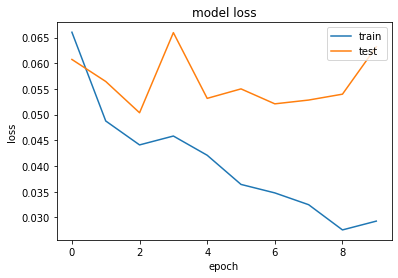

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()